- [ ] phase 的 pattern -> 是否提前打手；dataset as 光栅前的部分
- [ ] gamma band SVM -> 是否提前打手


In [15]:
from multiprocessing import Pool

import EEGAnalysis as ea
import h5py
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
import re, os
from tqdm import tqdm

from sklearn.decomposition import PCA, TruncatedSVD

In [2]:
tspec = np.linspace(-3,3,12000)

_dataset = h5py.File('./zhouchen-5-delta.h5', 'r')
# _dataset = h5py.File('./wuzhenwei-5-delta.h5', 'r')
# _dataset = h5py.File('./zhouchen-5-delta-tapping-lock.h5', 'r')

_dates = list(_dataset.keys())
print(_dates)

# _dataset.close()

tspec = np.linspace(-3,3,12000)

['180827', '180829', '180831', '180901', '180902', '180903', '180904']


In [3]:
_location = pd.read_csv('/media/STORAGE/EEG/electrode_layout/layout_zhouchen/zhouchen_tal_coord.td.fill.csv')
_location.head()

_behavior = pd.read_csv('../Step_3_Behavior_Stat/zhouchen-behavior-final.csv', dtype={'date':'str'})
check_behavior_prediction = lambda x,y: _behavior.time[(_behavior.paradigm == x) & (_behavior['date'] == y)].values < 0
_behavior.head()

,date,paradigm,time,trial
0,180827,1-10,0.52,1
1,180827,1-10,0.32,2
2,180827,1-10,-0.44,3
3,180827,1-10,-0.12,4
4,180827,1-10,-0.04,5


In [6]:
# _t = ['Brodmann area 17', 'Brodmann area 18', 'Brodmann area 19', ]  # Visual Cortex
_t = ['Brodmann area 23', 'Brodmann area 24', 'Brodmann area 31', 'Brodmann area 32', 'Brodmann area 33', ]  # cingulate cortex

_targets = np.ones(shape=(0,), dtype='int')
for item in _t:
    _stack = _location['Record Number'][_location['Level 5'] == item].values
    print(item, np.unique(_stack))
    _targets = np.hstack((_targets, _stack))
_targets = np.unique(_targets)
len(_targets)

Brodmann area 23 [  8   9 107 108]
Brodmann area 24 []
Brodmann area 31 [10 19 20 34 35 36]
Brodmann area 32 []
Brodmann area 33 []


10

In [22]:
_lens = np.where((-1 < tspec)&(tspec < 1))[0]

_trial = np.zeros((20, len(_targets), _lens.size), dtype='f8')

pbar = tqdm(total=len(_targets)*20)
for idx, chidx in enumerate(_targets):
    for tidx in range(20):
        _trial[tidx, idx, :] = np.angle(_dataset['180827']['1']['%03d'%(chidx-1)][tidx, _lens])
        pbar.update(1)
pbar.close()
# _trial = np.array(_trial)

100%|██████████| 200/200 [00:09<00:00, 18.75it/s]


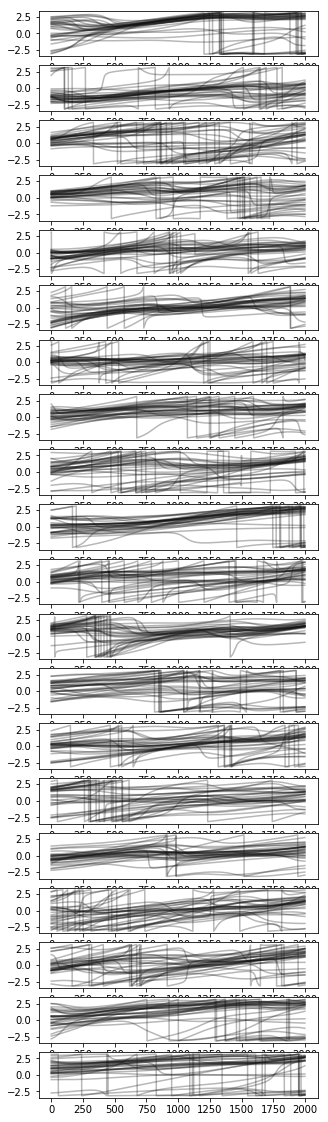

In [65]:
plt.figure(figsize=(5,20))

for i in range(20):
    plt.subplot(20,1,i+1)
    plt.plot(_trial[i].T, color='#111111', alpha=0.3)
plt.show()

In [36]:
# _batch = np.zeros((len(_lens)*20, len(_targets)))
# for i in range(20):
#     _batch[i*len(_lens):i*len(_lens)+len(_lens)] = _trial[i].T
_proj = TruncatedSVD(n_components=2).fit_transform(_trial.reshape((20, -1)))

In [37]:
_prediction = check_behavior_prediction('1-5', '180827')
_prediction

array([False, False, False,  True, False,  True, False,  True,  True,
        True,  True, False,  True,  True, False, False,  True,  True,
        True,  True])

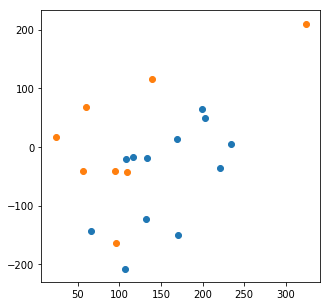

In [39]:
plt.figure(figsize=(5,5))
plt.scatter(_proj[_prediction, 0], _proj[_prediction, 1])
plt.scatter(_proj[~_prediction, 0], _proj[~_prediction, 1])
plt.show()

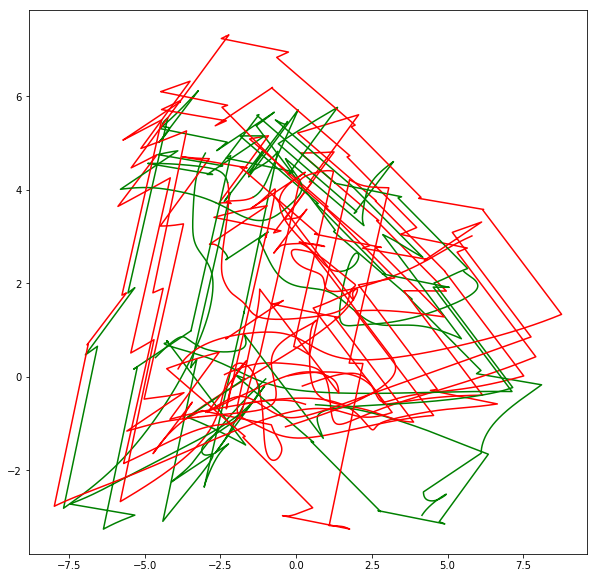

In [25]:
plt.figure(figsize=(10,10))
for i in range(20):
    if _prediction[i]:
        plt.plot(_proj[i*2000:i*2000+2000,0], _proj[i*2000:i*2000+2000,1], color='r')
    else:
        plt.plot(_proj[i*2000:i*2000+2000,0], _proj[i*2000:i*2000+2000,1], color='g')
plt.show()

(20, 40000)

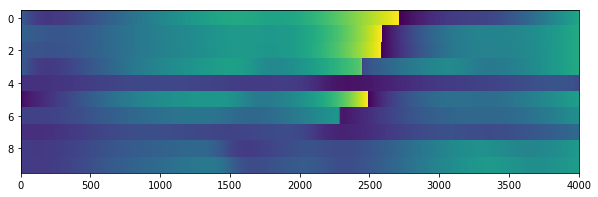

In [30]:
plt.figure(figsize=(10,3))
plt.imshow(_trial[1], aspect='auto')
plt.show()